In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def convert_strings_to_dates(dataframe, testset=False):
    frame = dataframe.copy()
    if testset:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    else:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [3]:
def convert_date_to_int(dataframe, columns):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    
    for col in columns:
        frame[f'{col}'] = [conversion(d) for d in frame[f'{col}']]

    return frame

In [4]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [5]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [6]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [7]:
def standardize_numericals(dataframe, columns=None):    
    scaler = StandardScaler()
    frame = None
    
    if columns:
        frame = dataframe[columns].copy()
    else:
        frame = dataframe.copy()
    
    x = scaler.fit_transform(frame)
    scaled_df = pd.DataFrame(x)
    scaled_df.columns = frame.columns

    
    if columns:
        frame = dataframe.copy()
        frame[columns] = scaled_df.values
    else:
        frame = scaled_df.copy()
    
    return frame

In [8]:
def impute_numericals(dataframe, columns, strategy='most_frequent', testset=False):
    frame = dataframe.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    for col in columns:
        imp.fit(frame[f'{col}'].values.reshape(-1, 1))
        frame[f'{col}'] = imp.transform(frame[f'{col}'].values.reshape(-1, 1))
    
    return frame

In [9]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    
    labels = (frame.total_loads > loads_percentile) & (frame.most_recent_load_date > most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    
    return frame

In [10]:
def get_Xy(dataframe, aggregate=False, standardize=False, testdata=False):
    frame = dataframe.copy()
    scaler = StandardScaler()
    if not testdata:
        loads_75th_percentile = dataframe["total_loads"].quantile(0.75)
    most_recent_75th_percentile = date(year=2021, month=2, day=10)


    if testdata:
        frame = convert_strings_to_dates(frame, testset=True)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        # The only columns not in the new frame should be booleans that are safely set to 0
        for col in dataframe.columns:
            if col not in frame.columns:
                frame[f'{col}'] = 0

        frame.drop(columns=['weekday'], inplace=True)
        frame = impute_numericals(frame, ['days_signup_to_approval'])

        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        return frame, None
    
    
    frame = convert_strings_to_dates(frame)
    
    if aggregate:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = aggregate_rows_by_driver_id(frame)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels
    else:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels

## Load CSV to DataFrame

In [11]:
train_df = pd.read_csv('training_dataset_V3.csv')
test_df = pd.read_csv('score_V3.csv')

**Drops duplicates and unwanted columns**

In [12]:
train_Ids = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
train_df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

test_Ids = test_df['Unnamed: 0']
test_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)

---

# 1 - Generate Labels and 4 - Pipeline

In [13]:
# Use this when you want to generate output for Kaggle
X_train, y_train = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_test, _ = get_Xy(test_df, standardize=True, aggregate=False, testdata=True)

In [14]:
# testing the number of labels
np.sum(np.array(y_train)) / len(y_train)

0.1519867176947321

In [15]:
# Use this for training/testing your model
X, y = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_train.shape, y_train.shape

((56857, 40), (56857,))

In [17]:
X_test.shape, y_test.shape

((14215, 40), (14215,))

# 3 - Statistical Analysis

# 5 - Linear Regression

# 6 - PCA

# 7 - Ensemble Method

# 8 - Neural Network

In [24]:
clf = MLPClassifier(hidden_layer_sizes=(100,), verbose=False)
clf.fit(np.array(X_train), y_train)

Iteration 1, loss = 0.21662635
Iteration 2, loss = 0.11372595
Iteration 3, loss = 0.07990988
Iteration 4, loss = 0.06031584
Iteration 5, loss = 0.04777204
Iteration 6, loss = 0.03861793
Iteration 7, loss = 0.03169323
Iteration 8, loss = 0.02615326
Iteration 9, loss = 0.02159401
Iteration 10, loss = 0.01806766
Iteration 11, loss = 0.01537772
Iteration 12, loss = 0.01311336
Iteration 13, loss = 0.01150955
Iteration 14, loss = 0.00999991
Iteration 15, loss = 0.00922159
Iteration 16, loss = 0.00798840
Iteration 17, loss = 0.00727250
Iteration 18, loss = 0.00659611
Iteration 19, loss = 0.00608509
Iteration 20, loss = 0.00555919
Iteration 21, loss = 0.00505982
Iteration 22, loss = 0.00469695
Iteration 23, loss = 0.00403753
Iteration 24, loss = 0.00395638
Iteration 25, loss = 0.00349652
Iteration 26, loss = 0.00313270
Iteration 27, loss = 0.00295166
Iteration 28, loss = 0.00265987
Iteration 29, loss = 0.00238573
Iteration 30, loss = 0.00221276
Iteration 31, loss = 0.00191105
Iteration 32, los

MLPClassifier(verbose=True)

In [27]:
clf.score(np.array(X_test), y_test)

0.9999296517762927

In [36]:
# learning curves
X_arr, y_arr = np.array(X_train), np.array(y_train)
cutoffs = 10

step = len(X_arr) // cutoffs
cuts = [step * i for i in range(1, cutoffs + 1)]
train_scores = []
test_scores = []

for cut in cuts:
    X_arr_cut = X_arr[:cut]
    y_arr_cut = y_arr[:cut]
    clf = MLPClassifier(hidden_layer_sizes=(100,))
    clf.fit(X_arr_cut, y_arr_cut)
    train_scores.append(clf.score(X_arr_cut, y_arr_cut))
    test_scores.append(clf.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


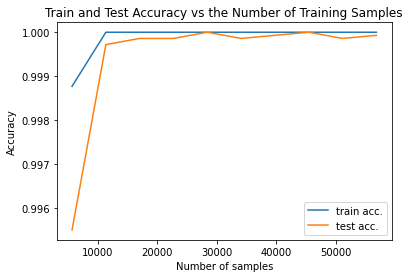

In [38]:
# plot
plt.plot(cuts, train_scores, label="train acc.")
plt.plot(cuts, test_scores, label="test acc.")
plt.legend(loc = "best")
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs the Number of Training Samples")
plt.show()

In [39]:
# Perform cross validation
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(clf, X_arr, y_arr, cv=10)
print(cross_val_scores)

[1.         1.         1.         1.         1.         0.99982413
 1.         1.         1.         1.        ]


In [45]:
print(np.mean(cross_val_scores))

0.9999824129440732


In [43]:
# Alternate model
clf2 = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='sgd', momentum=0.9)
cvs2 = cross_val_score(clf2, X_arr, y_arr, cv=10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

In [44]:
print(np.mean(cvs2))

0.9561179072114973


# 9 - Cross Validation

# 10 - Custom Model

In [ ]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)